In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from numpy.linalg import inv, pinv

tau = pi * 2

Modelled circuit
<img src="kolo.png" style = "width: 300px;">

Some madeup measurements:

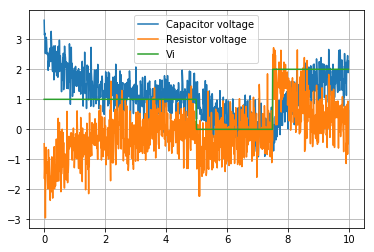

In [16]:
R1 = 1000e0
C1 = 1e-9
dt = 10e-9
N  = 1000
t  = np.linspace(start=0, stop=dt*(N-1), num=N)


Vi = np.ones(N) * 1
Vi[int(N/2):int(N*3/4)] = 0
Vi[int(N*3/4):N] = 2

V  = 3
vc = np.ones(N) * V
ir = np.ones(N) * (Vi-V)/R1

# noise variances for noise generation
svn = 4e-1
sin = 6e-4

#noise
vcn = np.random.normal(loc=0, scale=svn, size=(np.size(vc)))
irn = np.random.normal(loc=0, scale=sin, size=(np.size(ir)))


for i in range(1,N):
    vc[i] = vc[i-1] + (ir[i-1])*dt/C1
    ir[i] = (Vi[i-1]-vc[i-1])/R1
    
vc = vc + vcn
ir = ir + irn

plt.plot(t*1e6, vc)
plt.plot(t*1e6, ir*1e3)
plt.plot(t*1e6,Vi)
plt.legend(['Capacitor voltage','Resistor voltage','Vi'])
# plt.plot(t)
plt.grid(True)

In [17]:
P  = np.eye(2) #initial state covariance

# sensor noise covariance matrix Q?
Q = np.eye(2) * 1e-3

# sensor measurement covariance matrix R?
R = np.zeros_like(P)
R[0, 0] = svn * 1
R[1, 1] = sin * 1

# measurement sensor matrix H
H = np.eye(2)

#initial kalman gain
K  = P.dot(H.T).dot(np.linalg.pinv(H.dot(P).dot(H.T)+R))

print ("inv arg",H.dot(P).dot(H.T)+R)
print("K",K)

inv arg [[1.4    0.    ]
 [0.     1.0006]]
K [[0.71428571 0.        ]
 [0.         0.99940036]]


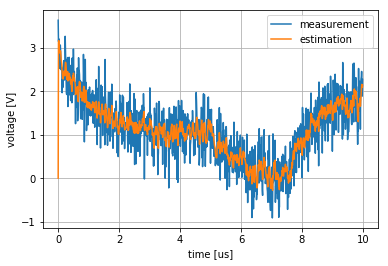

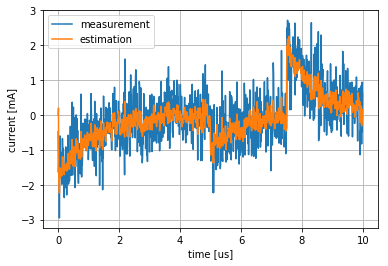

In [22]:
x  = np.zeros(shape=(N, 2))
xm = np.zeros(shape=(N, 2))
xm[:,0] = vc
xm[:,1] = ir
x_ = np.zeros_like(x)
u = Vi

#Voltage model jacobian with respect to last state
F = np.zeros(shape=(2, 2))
F[0] = np.array([1, dt/C1])
F[1] = np.array([-1/R1, 0])

#Voltage model jacobian with respect to noise
B = np.zeros(shape=(1,2))
B[:,1] = np.array([1/R1])

# covariance matrix P, initial guess
P  = np.eye(2)

# sensor noise covariance matrix Q?
Q = np.eye(2) * 1e-3

# sensor noise covariance matrix R
R = np.zeros_like(P)
R[0, 0] = svn * 2
R[1, 1] = sin * 4
# print(R)

# measurement sensor matrix H
H = np.eye(2)
# print(H)
# print(P)



for i in range(1,N):
    #predict    
    x[i]  = F.dot(x[i-1]) + B.dot(Vi[i])
    P     = F.dot(P).dot(F.T) + Q
    
    #update
    K     = P.dot(H.T).dot(pinv(H.dot(P).dot(H.T)+R))
    x[i]  = x[i] + K.dot(xm[i]-H.dot(x[i]))
    P     = P - K.dot(H).dot(P)



plt.figure(1)
plt.plot(t*1e6, xm[:,0]*1e0)
plt.plot(t*1e6, x[:,0]*1e0)
plt.xlabel('time [us]')
plt.ylabel('voltage [V]')
plt.grid(True)
plt.legend(['measurement', 'estimation'])
    
plt.figure(2)
plt.plot(t*1e6, xm[:,1]*1e3)
plt.plot(t*1e6, x[:,1]*1e3)
plt.xlabel('time [us]')
plt.ylabel('current [mA]')
plt.grid(True)
plt.legend(['measurement', 'estimation'])
